<a href="https://colab.research.google.com/github/guri634/FashionClassifier/blob/main/FashionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fashion Classifier**
This notebook builds an clothes image classifier using Tensorflow 2.0.

## Project Introduction

### 1. Problem

Identify the type of cloth given an image of a cloth.

### 2. Data

The data we're using is from Kaggle: https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full

### 3. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning or transfer learning.
* There are 20 type of clothes (this means there are 20 different classes).
* There are around 5000+ images of colthes which are splitted into training and test datasets.

## Reading Data

In [1]:
# import necessary libraries

import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image
import random

In [2]:
# Reading the images.csv file using pd.read_csv

images = pd.read_csv('/content/drive/MyDrive/FashionClassifier/images.csv')

# Displaying 5 rows from top of images.csv file
images.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [3]:
# Getting info about null values and datatypes
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      5403 non-null   object
 1   sender_id  5403 non-null   int64 
 2   label      5403 non-null   object
 3   kids       5403 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 132.0+ KB


In [4]:
# Viewing labels and their count
images['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

## Data Visulisation and preprocessing

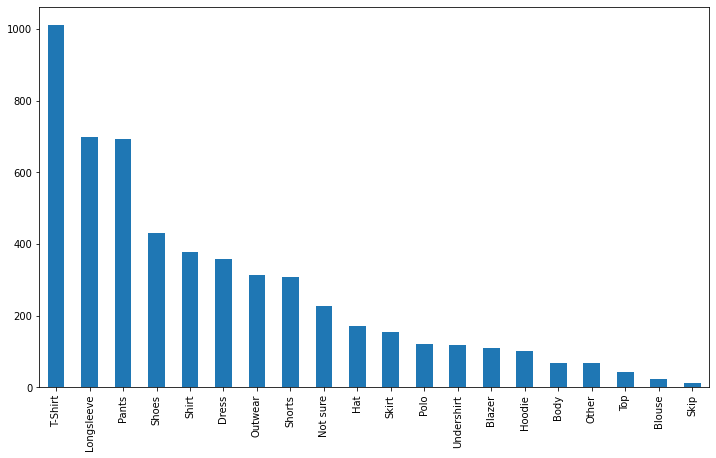

In [5]:
# Let us visualise barplot of label value counts
images['label'].value_counts().plot(kind='bar', figsize=(12,7))

In [6]:
# Dropping the rows which have label: Skip
images.drop(images[images['label'] == 'Skip'].index, inplace=True)
len(images)

5391

In [7]:
# Rename the Not sure value to Not_sure
images.loc[images['label']=='Not sure', 'label'] = 'Not_sure'

In [8]:
# Prepend image filenames in train/ with relative path
filenames = ['/content/drive/MyDrive/FashionClassifier/images_original/' + fname for fname in images['image'] + '.jpg']

# Converting the labels into boolean array
labels = images['label']
unique_values = np.unique(labels)
bool_labels = [label == unique_values for label in labels]
bool_labels = [label.astype(int) for label in bool_labels]

In [9]:
# Splitting the data into training and testing datasets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames, bool_labels, train_size=0.8, random_state=42)

# Checking the number of values in training data and testing data
num_train = len(train_filenames)
num_val = len(val_filenames)

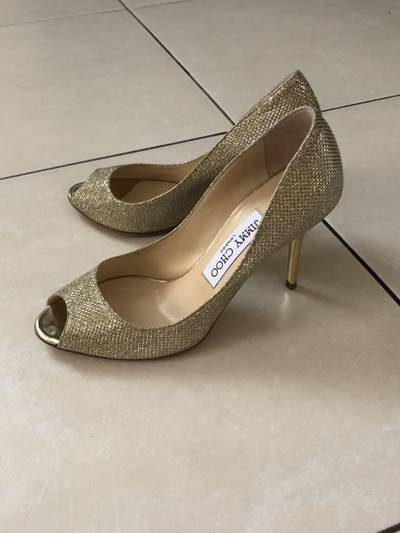

In [10]:
# Viewing a random image from our training data
img = random.choice(filenames)
Image(img)

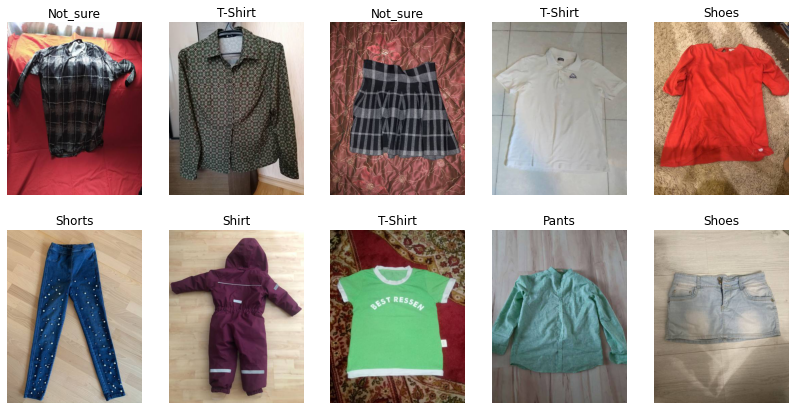

In [11]:
# Plotting a figure with 10 images
plt.figure(figsize=(14,7))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    img = plt.imread(random.choice(train_filenames))
    plt.imshow(img, aspect='auto')
    plt.title(unique_values[bool_labels[i].astype(int).argmax()])
    plt.axis('off')

In [12]:
# Declaring image size as 128
IMAGE_SIZE = 128

# Creating a function which preprocess the images
def _parse_fn(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = tf.image.convert_image_dtype(image_decoded, tf.float32)
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized, label

In [13]:
# Declaring batch size = 32 (i.e. 32 values per batch)
BATCH_SIZE = 32

# Creating tuples of our filenames and labels
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)

## Model training

In [14]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Base model with Xception
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                            classes=len(unique_values),
                                            include_top=False, 
                                            weights='imagenet')

# base_model.trainable = False

# Unfreeze all layers of Xception
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:10]:
    layer.trainable =  False

In [15]:
# Trainable classification head
input_layer = tf.keras.layers.Input(shape=IMG_SHAPE)
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(len(unique_values), activation='softmax')

In [16]:
learning_rate = 0.0001

# Creaing tensorflow model
model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 19)                38931     
                                                                 
Total params: 20,900,411
Trainable params: 20,817,371
Non-trainable params: 83,040
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# Declaring parameters for training
num_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 32

In [18]:
# Training the model for 10 epochs
history_xception = model.fit(train_data.repeat(),
                             epochs=num_epochs,
                             steps_per_epoch = steps_per_epoch,
                             validation_data=val_data.repeat(),
                             validation_steps=val_steps,
                             verbose=1)

Epoch 1/10
134/134 [==============================] - 58s 185ms/step - loss: 1.6130 - accuracy: 0.5462 - val_loss: 1.0275 - val_accuracy: 0.6895
Epoch 2/10
134/134 [==============================] - 45s 330ms/step - loss: 0.4897 - accuracy: 0.8533 - val_loss: 0.9496 - val_accuracy: 0.7207
Epoch 3/10
134/134 [==============================] - 35s 261ms/step - loss: 0.1205 - accuracy: 0.9694 - val_loss: 0.9271 - val_accuracy: 0.7539
Epoch 4/10
134/134 [==============================] - 34s 257ms/step - loss: 0.0321 - accuracy: 0.9944 - val_loss: 0.9604 - val_accuracy: 0.7402
Epoch 5/10
134/134 [==============================] - 34s 257ms/step - loss: 0.0168 - accuracy: 0.9977 - val_loss: 0.9464 - val_accuracy: 0.7607
Epoch 6/10
134/134 [==============================] - 35s 259ms/step - loss: 0.0059 - accuracy: 0.9998 - val_loss: 0.9785 - val_accuracy: 0.7598
Epoch 7/10
134/134 [==============================] - 34s 257ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 1.0596 - val_ac

In [19]:
# Save model weights
model.save_weights('weights_epoch_10.h5')

## Save and Load model

### Save Model

In [20]:
# Saving the model
model_dir = os.path.join('/content/drive/MyDrive/FashionClassifier/Models/')
model_path = model_dir + '_' + 'FashionClassificationUsingXception' + '.h5'
print(f'Saving Model to : {model_path} ,...')
model.save(model_path)
print('Model Saved.')

Saving Model to : /content/drive/MyDrive/FashionClassifier/Models/_FashionClassificationUsingXception.h5 ,...
Model Saved.


In [21]:
# Checking model loss and accuracy on test data before saving
model.evaluate(val_data, verbose=1)

34/34 [==============================] - 4s 107ms/step - loss: 1.0965 - accuracy: 0.7257


[1.0965379476547241, 0.7256719470024109]

 ### Load Model

In [22]:
print(f'Loading model from: {model_path} ,...')
model = tf.keras.models.load_model(model_path)
print('Model Loaded')

Loading model from: /content/drive/MyDrive/FashionClassifier/Models/_FashionClassificationUsingXception.h5 ,...
Model Loaded


In [23]:
# Checking model loss and accuracy on test data after loading
model.evaluate(val_data, verbose=1)

34/34 [==============================] - 5s 115ms/step - loss: 1.0965 - accuracy: 0.7257


[1.0965379476547241, 0.7256719470024109]

## Model Testing

In [24]:
# Function for plotting Accuracy and Loss plots
def acc_loss_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

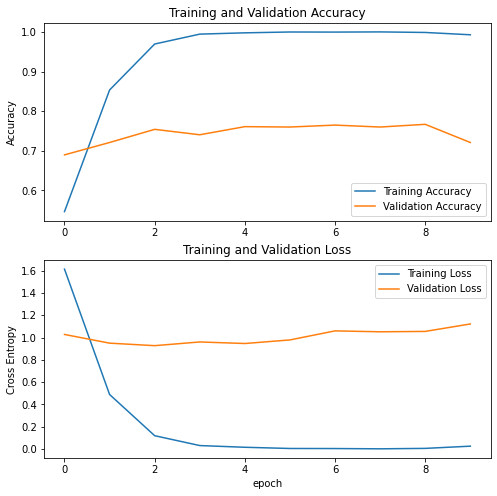

In [25]:
# Plot of Accuracy and Loss
acc_loss_plot(history_xception)

In [26]:
# Make predictions on the test data (not used to train on)
preds = model.predict(val_data, verbose=1)

34/34 [==============================] - 4s 96ms/step


In [27]:
# Check the shape of predictions
preds.shape

(1079, 19)

In [28]:
# Debatch the test data
val_images = []
val_labels = []

for img, lb in val_data.unbatch().as_numpy_iterator():
    val_images.append(img)
    val_labels.append(lb)

In [33]:
# Check precision score
from sklearn.metrics import accuracy_score
accuracy_score(val_labels, np.round(preds).astype(int))

0.6858202038924931

In [30]:
# Function for plotting the predicted image with label
def plot_pred(pred_probs, labels, images, n=1):
    pred_prob, true_label, img = pred_probs[n], unique_values[np.argmax(labels[n])], images[n]
    pred_label =  unique_values[np.argmax(pred_probs[n])]

    plt.figure(figsize=(10,7))
    plt.imshow(img)
    plt.axis('off')

# Set green and red color for true and false predictions respectively  
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f'Pred = {pred_label}, {np.max(pred_prob)*100:2.0f}%, True = {true_label}', color=color)

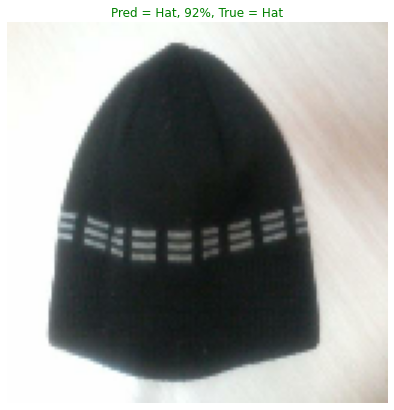

In [41]:
# Checking the random prediction
n = random.choice(range(len(preds)))

plot_pred(preds, val_labels, val_images, n=n)